In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from tqdm import tqdm


pd.set_option('display.max_columns', None)

### Read in Used Cars Dataset

In [78]:
# Read in used car data and quickly inspect
df = pd.read_csv('cars.csv')

print(f'# of rows = {df.shape[0]}\n# of cols = {df.shape[1]}')
display(df.head())

# of rows = 38531
# of cols = 30


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable,location_region,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,10900.00,False,Минская обл.,9,13,False,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,universal,False,owned,all,5000.00,True,Минская обл.,12,54,False,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,suv,False,owned,all,2800.00,True,Минская обл.,4,72,False,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,sedan,False,owned,all,9999.00,True,Минская обл.,9,42,True,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,universal,False,owned,all,2134.11,True,Гомельская обл.,14,7,False,True,False,True,True,False,False,False,False,True,7


### Preprocess data

In [80]:
# Check for any null values
print('columns that contain null values')
print('='*35)
for col in df.columns[df.isna().any() == True]:
    print(col, df[col].dtype)
    df[col].fillna(df[col].mean(), inplace=True)

columns that contain null values
engine_capacity float64


#### Label Encode categorical columns

In [15]:
# Label Encode all categorical columns
cat_cols = df.columns[(df.dtypes == object) | (df.dtypes == bool)].values

df_encoded = df.copy()
df_encoded[cat_cols] = df_encoded[cat_cols].apply(LabelEncoder().fit_transform)

#### Standard Scale all columns

In [16]:
# Now that all the data is numeric, we need to scale it so that all the features are on the same scale
df_scaled = df_encoded.copy()

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    StandardScaler().fit_transform(df_scaled),
    columns=df_scaled.columns
)

#### Use PCA to reduce the dimensionality of the dataset

In [60]:
# There are 30 features in this dataset, which can be considered as a lot
# We are going to use PCA to reduce the dimensionality of this dataset
# Note that n_components = 0.8 means that PCA will reduce the dimensionality of the dataset
# to where 80% of the total variance can be explained
n_components = 0.8
pca = PCA(n_components=n_components).fit(df_scaled)

df_pca = pd.DataFrame(
    pca.transform(df_scaled))
df_pca.columns = [f'pc{i}' for i in range(1, df_pca.shape[1]+1)]
df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,3.534158,1.083594,0.150272,-0.668187,0.055107,1.618084,-0.859715,-0.319079,0.210072,-0.207994,1.137171,-0.579025,-0.925242,-0.258250,0.689684,0.027975
1,1.437454,0.367971,-0.913709,1.379602,-0.686560,2.751711,1.148578,1.049791,-1.649620,-0.148853,0.317214,-0.891782,-0.585246,-0.220807,0.623900,-0.662993
2,0.177945,0.111678,-1.113039,1.322030,0.755878,1.959192,1.140605,0.581124,-0.277692,-0.463395,1.206566,-0.740448,-0.645587,-1.181252,1.033238,-0.151307
3,-1.549081,1.689892,0.936128,1.831028,-0.887694,1.328319,-1.015557,1.202069,-1.083304,0.417269,-0.863497,-0.519420,-0.245544,-1.597742,0.737703,-0.684205
4,1.112148,0.354423,-0.801063,0.160243,-1.234515,2.198792,1.290651,0.817992,-1.017161,1.136688,-0.508214,-1.055405,-0.430276,-0.121178,0.829289,-0.200063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,1.588567,-0.604487,-2.886070,2.706453,-0.171354,-0.057953,1.008444,0.115153,0.232463,-1.357882,1.503225,-1.115733,0.107060,-0.634077,0.058091,-1.220250
38527,0.746318,-2.428926,-0.750067,0.747767,1.310277,0.071195,1.914389,-0.809717,-0.199705,1.745164,-0.453125,-0.446956,2.234657,-0.586141,-0.643226,-0.905426
38528,1.243885,-1.950292,-3.516059,2.355716,-0.613244,0.468997,0.685490,-1.272786,-1.645453,-1.765664,0.549603,-0.535608,0.243392,0.691593,-0.080832,-0.345448
38529,-0.564239,0.312396,-2.040397,3.809863,2.954000,0.046283,1.454604,-0.528693,0.096064,1.442122,-1.715045,-1.403683,1.062412,-1.025710,-0.917416,0.539628


In [67]:
print(f'Number of features reduced with PCA = {len(df.columns) - len(df_pca.columns)}')
print(f'Total explained variance ratio = {sum(pca.explained_variance_ratio_):.3f}')


Number of features reduced with PCA = 14
Total explained variance ratio = 0.815


### Perform KMeans clustering

In [61]:
def kmeans_clustering(X, n_clusters, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_

In [77]:
n_clusters_opts = range(1, 40)

distortions = []
inertias = []
for n_clusters in tqdm(n_clusters_opts, desc='Fitting with varying cluster sizes'):
    labels, centers, inertia = kmeans_clustering(df_scaled.values, n_clusters=n_clusters)
    inertias += [inertia]

Fitting with varying cluster sizes: 100%|██████████| 39/39 [01:42<00:00,  2.63s/it]


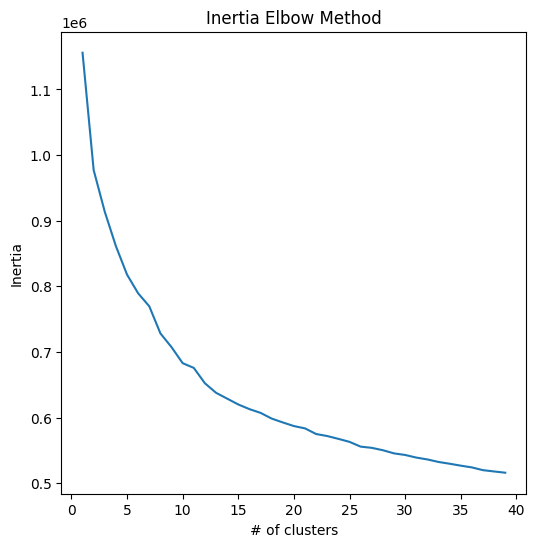

In [79]:
plt.figure(1, figsize=(6, 6))

plt.title('Inertia Elbow Method')
plt.plot(n_clusters_opts, inertias)
plt.ylabel('Inertia')
plt.xlabel('# of clusters');

### Elbow method insights

Selecting the optimal amount of clusters for this dataset is tricky. The plot of the inertia values for each n_cluster parameter is smooth, so selecting a n_cluster parameter using this method is not robust.

For n_clusters = 5 The average silhouette_score is : 0.14054636401053425
For n_clusters = 7 The average silhouette_score is : 0.14397910733986646
For n_clusters = 9 The average silhouette_score is : 0.13506646851478768
For n_clusters = 11 The average silhouette_score is : 0.13836931428189378
For n_clusters = 13 The average silhouette_score is : 0.13612028088281014
For n_clusters = 15 The average silhouette_score is : 0.13150258089520914


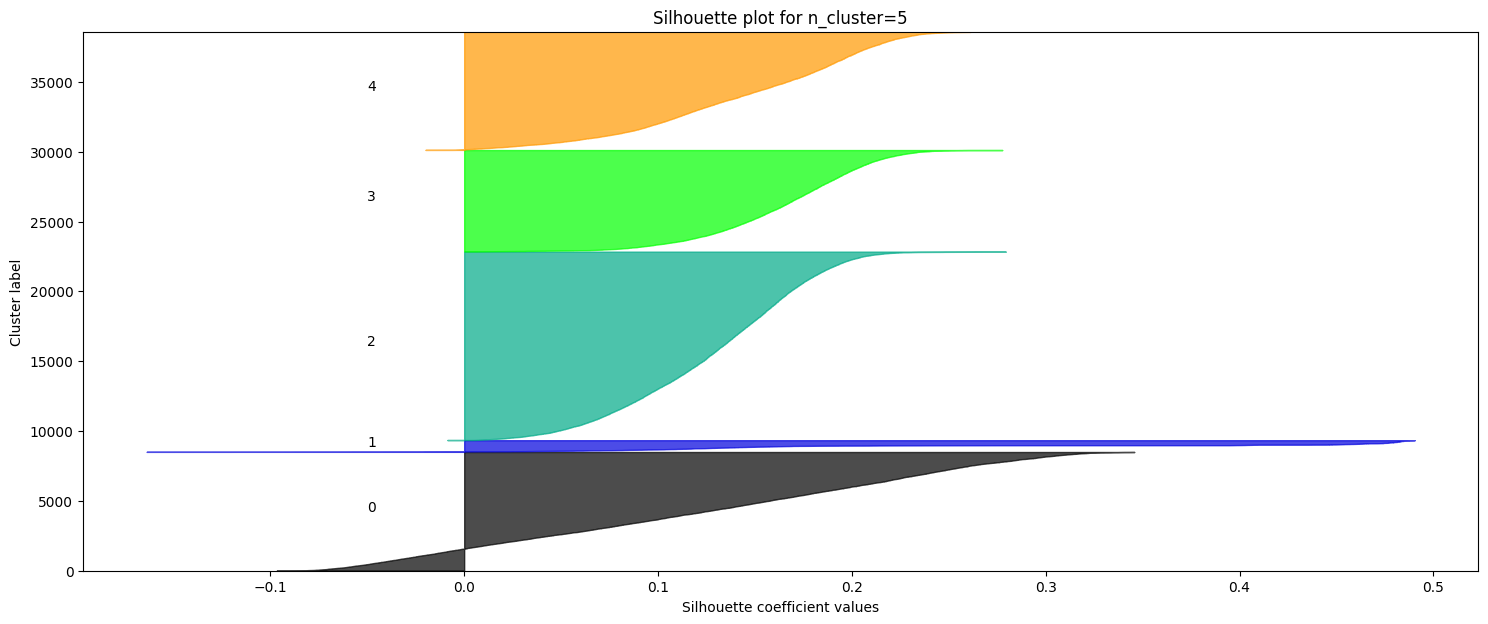

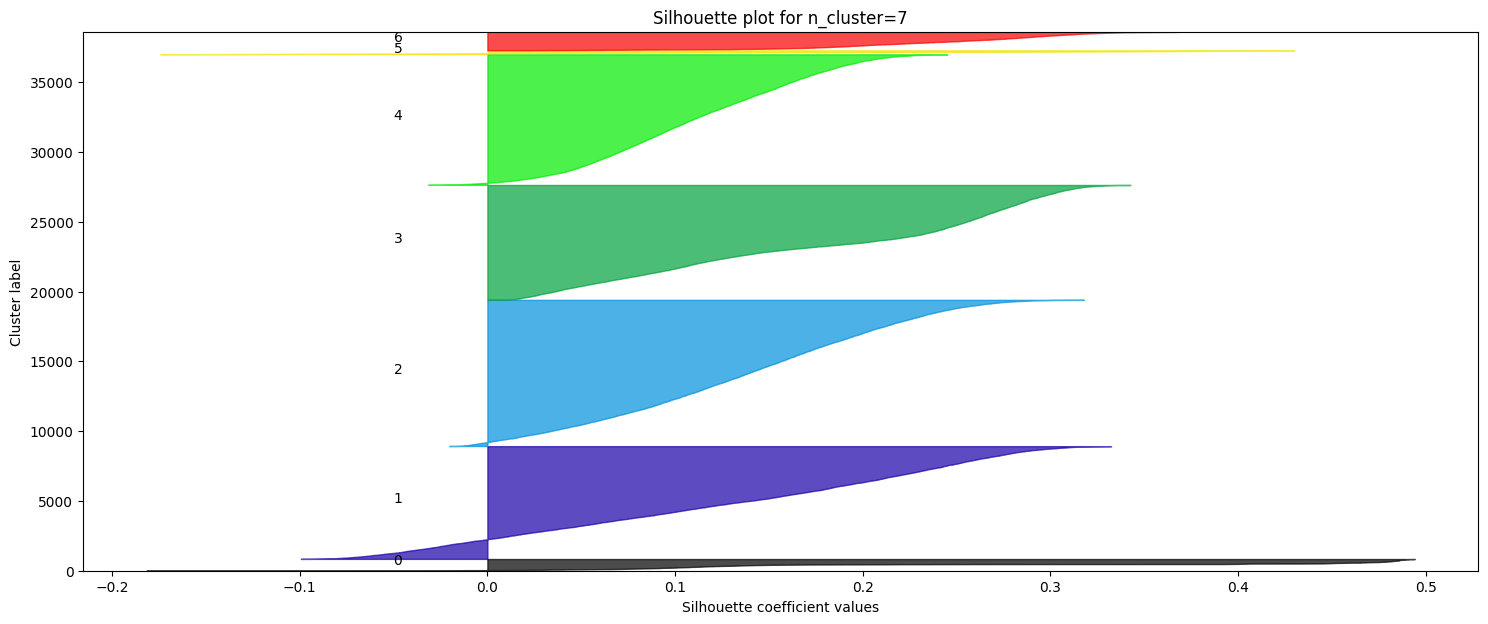

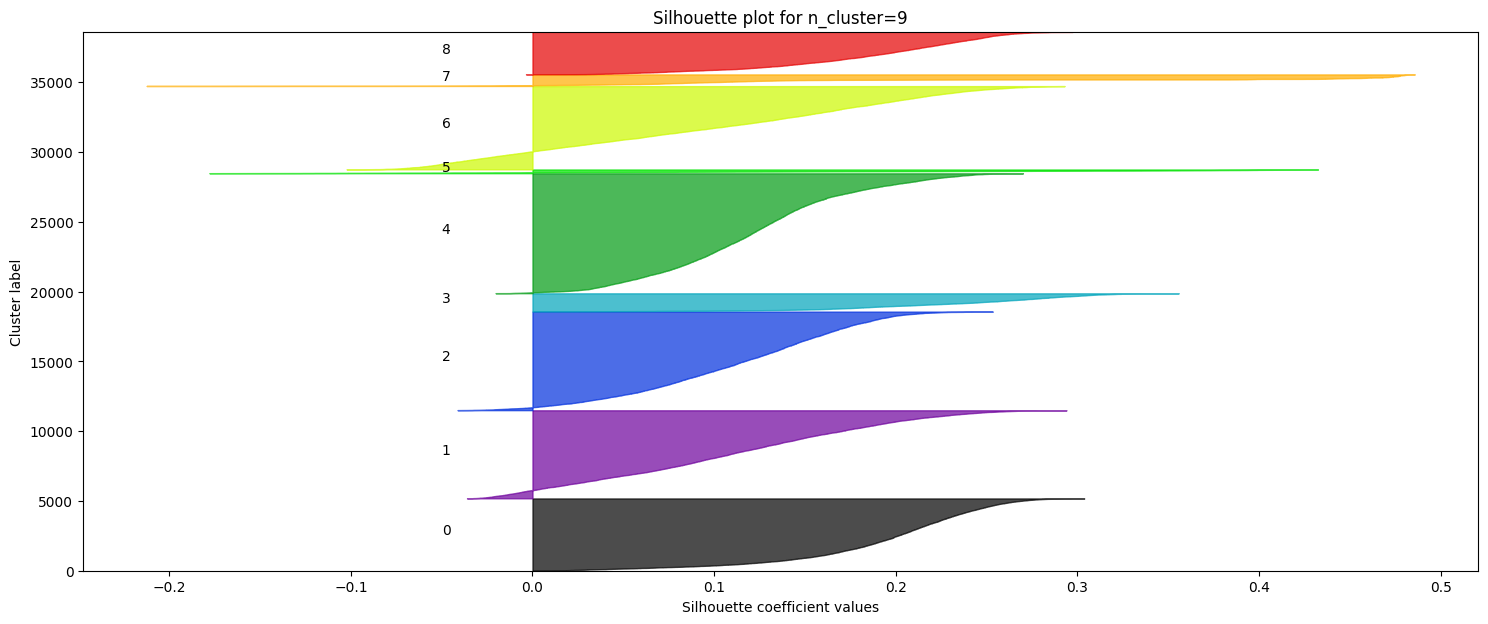

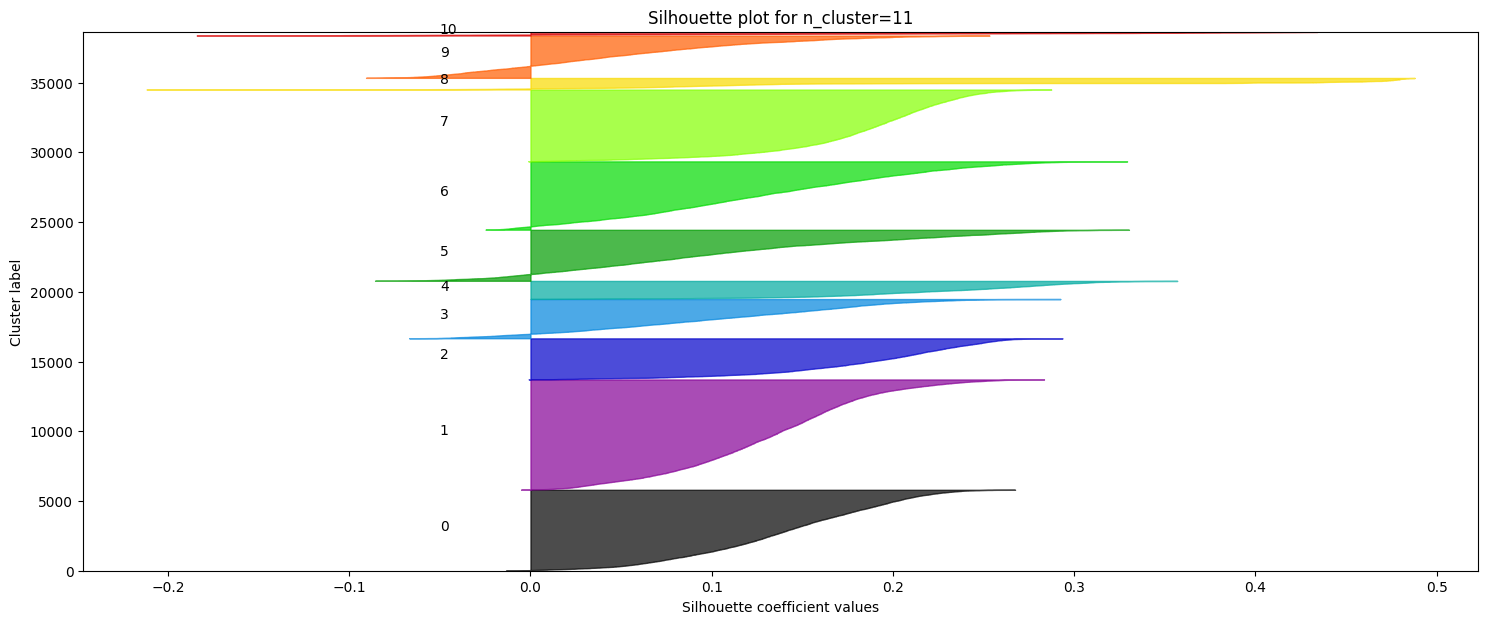

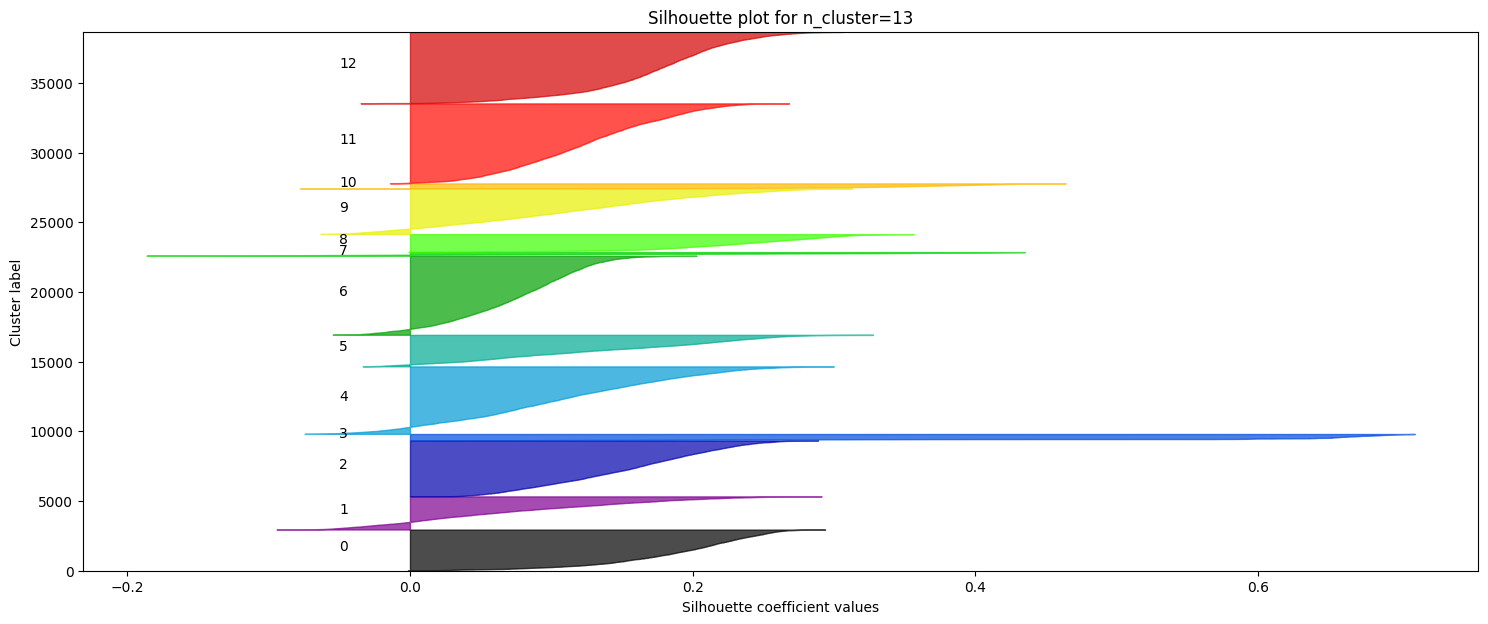

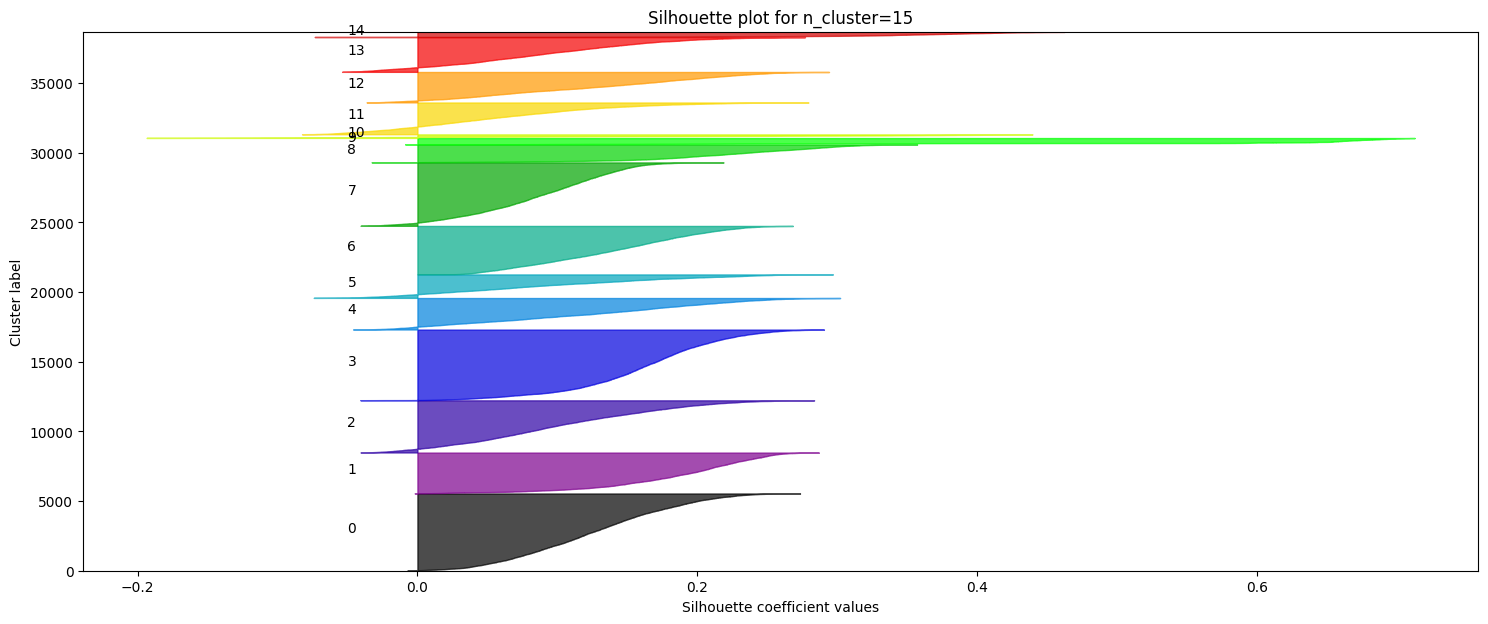

In [87]:
# Silhouette analysis was followed by provided code in the link below
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

n_clusters_opts = [5, 7, 9, 11, 13, 15]

for n_clusters in n_clusters_opts:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca.values) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette plot for n_cluster={n_clusters}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

### Silhouette analyis insights

This analysis gives a better insight on what the optimal n_cluster parameter should be. With insight provided by the Elbow method, the silhouette analysis is focused on a range of 5-15 n_clusters. This is because this range falls right around the elbow shown in the elbow plot.

From the plots above, it seems like a n_cluster parameter of 7 is most optimal because the average size of each cluster is roughly the same, with the exception of cluster 0 and 5. All other n_cluster parameters have a high variation in cluster sizes which is less ideal for our dataset.